In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os
import math
import random

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.6
Tensorflow version: 2.5.0
Keras version: 2.5.0


In [10]:
# Load the TensorBoard notebook extension.
# %reload_ext tensorboard
%load_ext tensorboard

In [11]:
# Clear any logs from previous runs.
!rm -rf ./logs/

In [12]:
# See available datasets
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'd4rl_adroit_door',
 'd4rl_adroit_hammer',
 'd4rl_adroit_pen',
 'd4rl_adroit_relocate',
 'd4rl_mujoco_ant',
 'd4

In [13]:
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

Dataset rock_paper_scissors downloaded and prepared to tmp/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [15]:
print('Raw train dataset:', dataset_train_raw)
print('Raw train dataset size:', len(list(dataset_train_raw)), '\n')

print('Raw test dataset:', dataset_test_raw)
print('Raw test dataset size:', len(list(dataset_test_raw)), '\n')

Raw train dataset: <PrefetchDataset shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
Raw train dataset size: 2520 

Raw test dataset: <PrefetchDataset shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
Raw test dataset size: 372 



In [16]:
dataset_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_path='tmp/rock_paper_scissors/3.0.0',
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
)

In [17]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)

Number of TRAIN examples: 2520
Number of TEST examples: 372
Number of label classes: 3


In [18]:
INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

INPUT_IMG_SIZE_REDUCED = INPUT_IMG_SIZE_ORIGINAL // 2
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)

# Here we may switch between bigger or smaller image sized that we will train our model on.
INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

print('Input image size (original):', INPUT_IMG_SIZE_ORIGINAL)
print('Input image shape (original):', INPUT_IMG_SHAPE_ORIGINAL)
print('\n')
print('Input image size (reduced):', INPUT_IMG_SIZE_REDUCED)
print('Input image shape (reduced):', INPUT_IMG_SHAPE_REDUCED)
print('\n')
print('Input image size:', INPUT_IMG_SIZE)
print('Input image shape:', INPUT_IMG_SHAPE)

Input image size (original): 300
Input image shape (original): (300, 300, 3)


Input image size (reduced): 150
Input image shape (reduced): (150, 150, 3)


Input image size: 150
Input image shape: (150, 150, 3)


In [19]:
# Function to convert label ID to labels string.
get_label_name = dataset_info.features['label'].int2str

In [20]:
print(get_label_name(0));
print(get_label_name(1));
print(get_label_name(2));

rock
paper
scissors


In [21]:
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

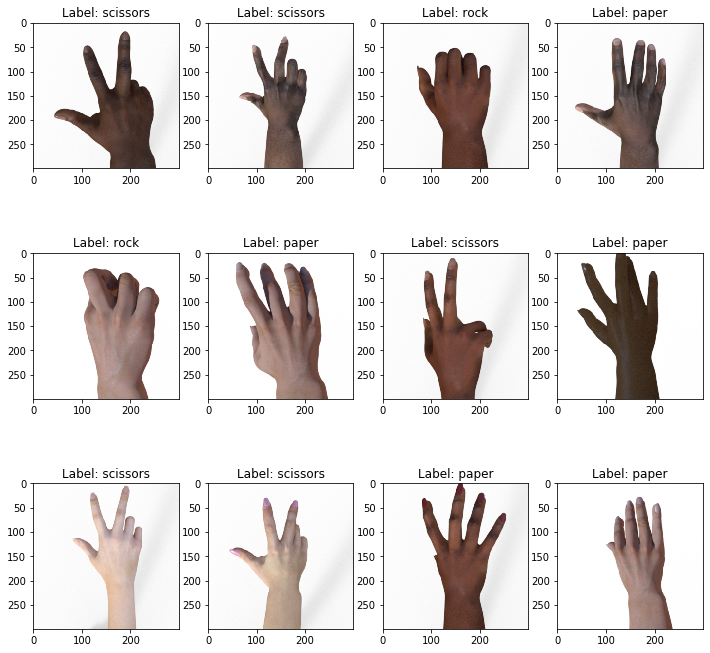

In [22]:
# Explore raw training dataset images.
preview_dataset(dataset_train_raw)

In [23]:
# Explore what values are used to represent the image. 
(first_image, first_lable) = list(dataset_train_raw.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 2 

Image shape: (300, 300, 3) 

[[[254 254 254]
  [253 253 253]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [250 250 250]]

 [[254 254 254]
  [254 254 254]
  [253 253 253]
  ...
  [250 250 250]
  [251 251 251]
  [249 249 249]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [252 252 252]]

 ...

 [[252 252 252]
  [251 251 251]
  [252 252 252]
  ...
  [247 247 247]
  [249 249 249]
  [248 248 248]]

 [[253 253 253]
  [253 253 253]
  [251 251 251]
  ...
  [248 248 248]
  [248 248 248]
  [248 248 248]]

 [[252 252 252]
  [253 253 253]
  [252 252 252]
  ...
  [248 248 248]
  [247 247 247]
  [250 250 250]]]


PRE-PROCESSAMENTO

In [24]:
def format_example(image, label):
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [25]:
dataset_train = dataset_train_raw.map(format_example)
dataset_test = dataset_test_raw.map(format_example)

In [26]:
# Explore what values are used to represent the image. 
(first_image, first_lable) = list(dataset_train.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 2 

Image shape: (150, 150, 3) 

[[[0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  ...
  [0.9852941  0.9852941  0.9852941 ]
  [0.9843137  0.9843137  0.9843137 ]
  [0.98039216 0.98039216 0.98039216]]

 [[0.99607843 0.99607843 0.99607843]
  [0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  ...
  [0.98333335 0.98333335 0.98333335]
  [0.9813726  0.9813726  0.9813726 ]
  [0.98333335 0.98333335 0.98333335]]

 [[0.99607843 0.99607843 0.99607843]
  [0.9941176  0.9941176  0.9941176 ]
  [0.9941176  0.9941176  0.9941176 ]
  ...
  [0.9852941  0.9852941  0.9852941 ]
  [0.9852941  0.9852941  0.9852941 ]
  [0.9813726  0.9813726  0.9813726 ]]

 ...

 [[0.9862745  0.9862745  0.9862745 ]
  [0.98725486 0.98725486 0.98725486]
  [0.9882353  0.9882353  0.9882353 ]
  ...
  [0.9705882  0.9705882  0.9705882 ]
  [0.97352946 0.97352946 0.97352946]
  [0.9754902  0.9754902  0.9754902 ]]

 [[0.9882353  0.9882353  0.9882353

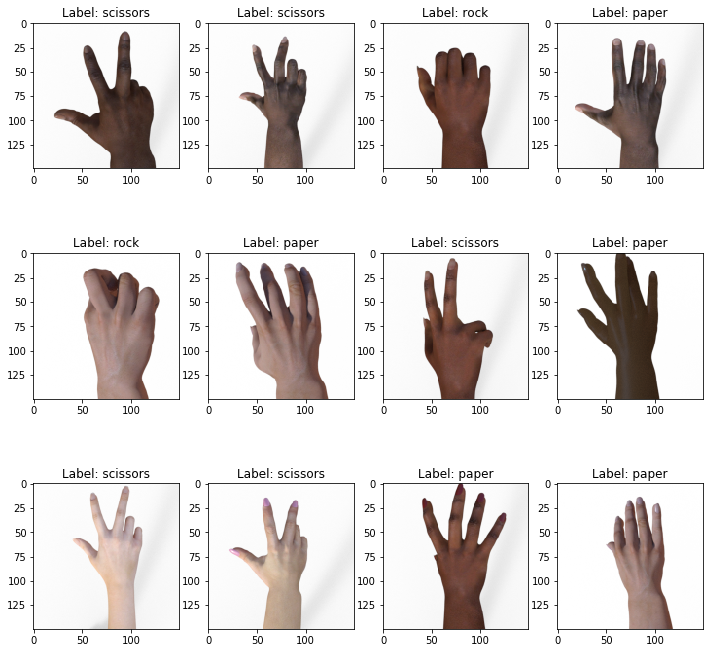

In [27]:
# Explore preprocessed training dataset images.
preview_dataset(dataset_train)

AUGMENTATION

In [28]:
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

In [30]:
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image

In [31]:
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

In [32]:
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [33]:
def augment_zoom(image: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:
    image_width, image_height, image_colors = image.shape
    crop_size = (image_width, image_height)

    # Generate crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(min_zoom, max_zoom, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize(
            [img],
            boxes=boxes,
            box_indices=np.zeros(len(scales)),
            crop_size=crop_size
        )
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: image, lambda: random_crop(image))

In [34]:
def augment_data(image, label):
    image = augment_flip(image)
    image = augment_color(image)
    image = augment_rotation(image)
    image = augment_zoom(image)
    image = augment_inversion(image)
    return image, label

In [35]:
dataset_train_augmented = dataset_train.map(augment_data)

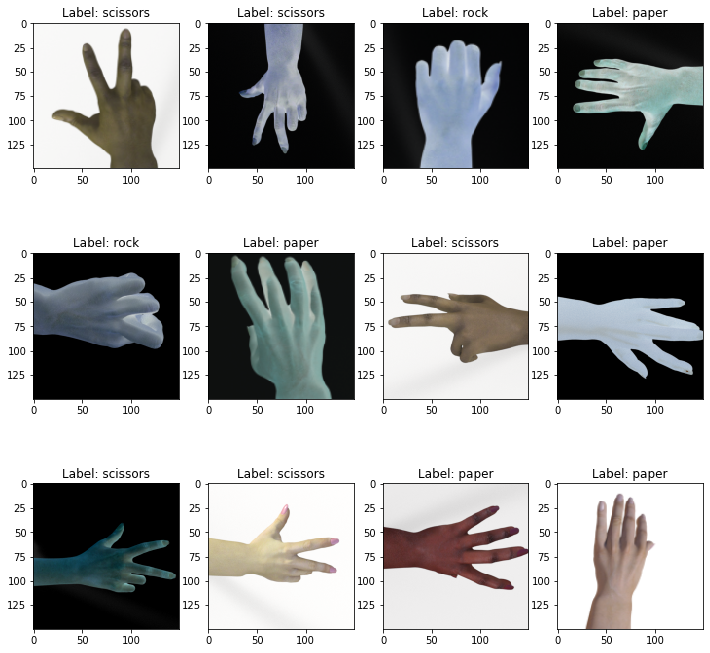

In [36]:
# Explore augmented training dataset.
preview_dataset(dataset_train_augmented)

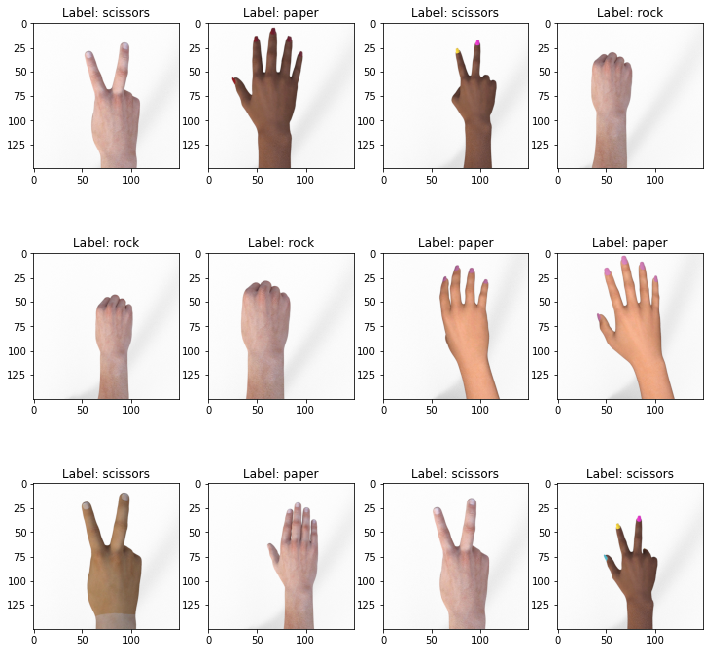

In [37]:
# Explore test dataset.
preview_dataset(dataset_test)

SHUFFLING AND BATCHING

In [38]:
BATCH_SIZE = 32

dataset_train_augmented_shuffled = dataset_train_augmented.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_train_augmented_shuffled = dataset_train_augmented.batch(
    batch_size=BATCH_SIZE
)

# Prefetch will enable the input pipeline to asynchronously fetch batches while your model is training.
dataset_train_augmented_shuffled = dataset_train_augmented_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test_shuffled = dataset_test.batch(BATCH_SIZE)

In [39]:
print(dataset_train_augmented_shuffled)
print(dataset_test_shuffled)

<PrefetchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int64)>


Label batch shape: (32,) 

Image batch shape: (32, 150, 150, 3) 

Label batch: [2 2 0 1 0 1 2 1 2 2 1 1 2 1 1 1 1 1 1 1 1 0 0 0 0 1 1 2 2 2 0 0] 

First batch image: [[[0.9959594  0.99522483 0.99435353]
  [0.9932209  0.99248636 0.991615  ]
  [0.99139535 0.9906608  0.9897894 ]
  ...
  [1.         0.99978876 0.99891746]
  [1.         0.99978876 0.99891746]
  [0.9996106  0.998876   0.9980047 ]]

 [[0.99139535 0.9906608  0.9897894 ]
  [0.99230814 0.9915736  0.9907022 ]
  [0.99230814 0.9915736  0.9907022 ]
  ...
  [0.9986978  0.9979632  0.9970919 ]
  [0.9996106  0.998876   0.9980047 ]
  [0.9996106  0.998876   0.9980047 ]]

 [[0.9932209  0.99248636 0.991615  ]
  [0.99139535 0.9906608  0.9897894 ]
  [0.9932209  0.99248636 0.991615  ]
  ...
  [0.9986978  0.9979632  0.9970919 ]
  [0.9996106  0.998876   0.9980047 ]
  [0.9996106  0.998876   0.9980047 ]]

 ...

 [[0.9795289  0.9787943  0.9779229 ]
  [0.974052   0.9733174  0.9724461 ]
  [0.97679037 0.97605574 0.97518444]
  ...
  [0.99048257 0.98974

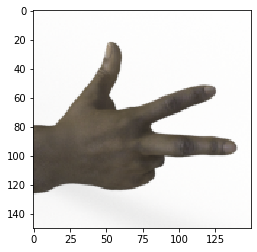

In [40]:
# Debugging the batches using conversion to Numpy arrays.
batches = tfds.as_numpy(dataset_train_augmented_shuffled)
for batch in batches:
    image_batch, label_batch = batch
    print('Label batch shape:', label_batch.shape, '\n')
    print('Image batch shape:', image_batch.shape, '\n')
    print('Label batch:', label_batch, '\n')
    
    for batch_item_index in range(len(image_batch)):
        print('First batch image:', image_batch[batch_item_index], '\n')
        plt.imshow(image_batch[batch_item_index])
        plt.show()
        # Break to shorten the output.
        break
    # Break to shorten the output.
    break

CREATING THE MODEL